# STROJNO UČENJE - PROJEKT
## EDA Student Performance Dataset
### Predviđanje uspjeha učenika pomoću demografskih i socio-ekonomskih informacija

# Sadržaj
[Library Import](#Library-import)

[Vizualizacija podataka](#Vizualizacija-podataka)

- [Kategoričke varijable](#Kategoričke-značajke)

- [Numeričke varijable](#Numeričke-značajke)

- [Usporedba spola](#Usporedba-spola)


[Feature Selection](#Feature-selection-&-encoding)

[Modeli](#Modeli)
- [Priprema podataka](#Priprema-podataka)

    -[Label Encoding](#Label-encoding)
    
    -[Train-test Split](#Train-Test-Split)

- [Regresija](#Modeli-linearne-regresije)

    -[Linearna Regresija](#Linearna-regresija)
    
    -[Lasso](#MultitaskLasso-Regresija-(3-izlaza))
    
    -[Ridge](#Ridge-regresija)
   
- [Slučajne šume](#slučajne-šume)

# Library import

In [1]:
#%% Imports


#SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection 

import squarify
from sklearn.pipeline import Pipeline


# Basic Imports 
import numpy as np
import pandas as pd

# Plotting 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

# Metrics 
import sklearn.metrics
from sklearn.metrics import *

# ML Models
import lightgbm as lgb
from lightgbm import LGBMRegressor 
import xgboost as xg 
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge
# Model Tuning 
from bayes_opt import BayesianOptimization

# Feature Importance 
import shap

# Ignore Warnings 
import warnings
warnings.filterwarnings('ignore')



# Import dataseta

In [2]:
df = pd.read_csv('StudentsPerformance.csv')

df['AVERAGE'] = df[['math score', 'reading score','writing score']].mean(axis=1)

# Vizualizacija podataka

In [3]:

df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,AVERAGE
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


Skup podataka sastoji se od 8 stupaca i 1000 redaka, odnosno podataka o studentima:

In [4]:
df.shape

(1000, 9)

## Kategoričke značajke

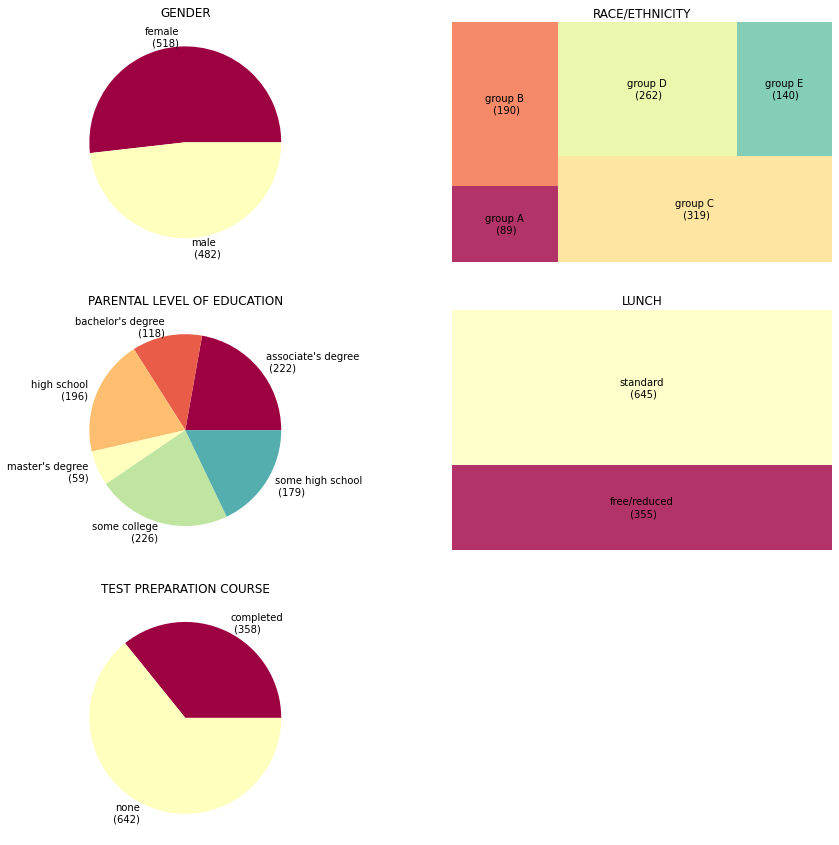

In [5]:
f, axes=plt.subplots(3, 2, figsize=(15, 15))
for i in range(5):
    plt.subplot(3, 2, i+1)
    
    df_grouped= df.groupby(df.columns[i]).size().reset_index(name='counts')
    labels = df_grouped.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
    sizes = df_grouped['counts'].values.tolist()
    colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]
    
    if i % 2 == 1:
       squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)
    else:
        plt.pie(sizes, labels=labels, colors=colors)
    plt.title(df.columns[i].upper())
    plt.axis('off')
    
plt.subplot(3, 2, 6)
plt.axis('off')
plt.show()

## Swarmplot kategoričkih atributa po oznaci,tj. broju bodova

<AxesSubplot:xlabel='parental level of education', ylabel='AVERAGE'>

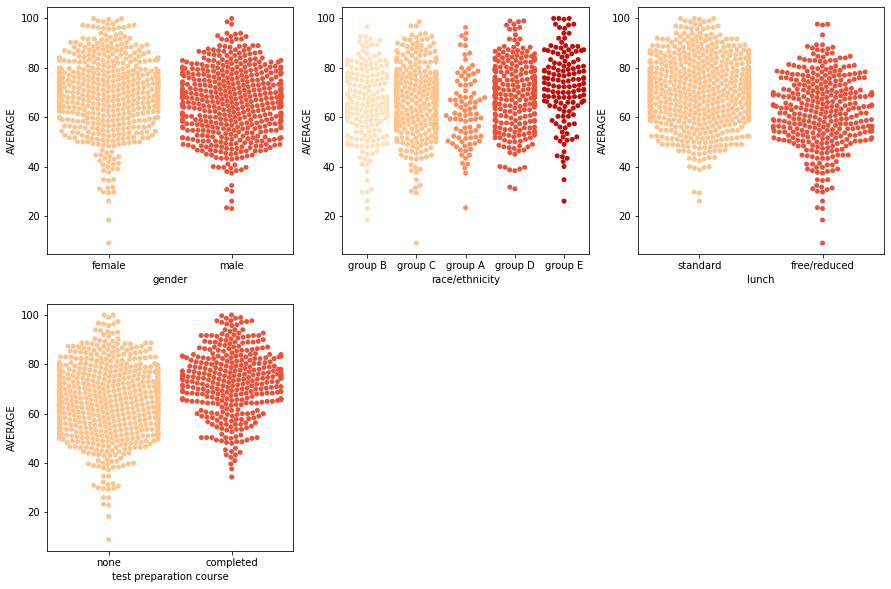

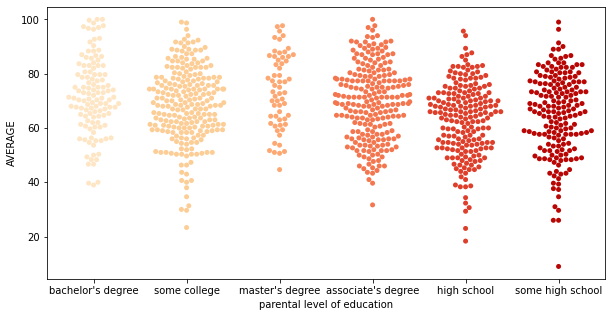

In [6]:
table=df.copy()
table = table.drop(["math score","reading score","writing score","AVERAGE","parental level of education"],axis = 'columns') 

plt.figure(figsize=(15,10))
for indx,val in enumerate(table.columns):
    plt.subplot(2,3,indx+1)
    sns.swarmplot(x=df[val],y=df['AVERAGE'],palette='OrRd')

plt.figure(figsize=(10,5))
sns.swarmplot(x=df['parental level of education'],y=df['AVERAGE'],palette='OrRd')
    

## Numeričke značajke

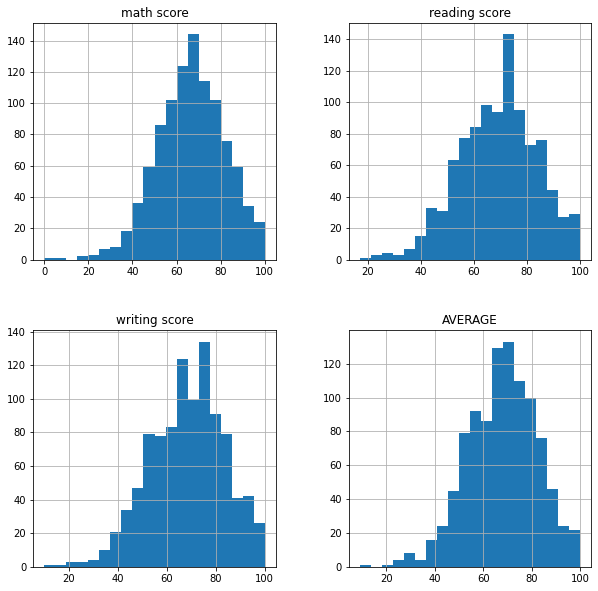

In [7]:
df.hist(figsize=(10,10),bins = 20)
plt.show()

# Feature selection & encoding

## Kodiranje atributa

Moramo napraviti preinake u našim podacima. Točnije, smetaju nam kategoričke varijable pošto algoritmi strojnog učenja ne rade sa kategoričkim varijablama. Postoji više pristupa tom problemu: 

    - One Hot Encoding (funkcija get_dummies)
    - Biblioteka LabelEncoder
    - Ručno, pomoću funkcije replace
    
Referenca: https://pbpython.com/categorical-encoding.html

In [8]:
# moramo napraviti label encoding
# pogledajmo prvo koje su nam vrijednosti u svakom stupcu
for col in df:
    if col == 'math score':
        break
    print(col, ' --> ', df[col].unique())

gender  -->  ['female' 'male']
race/ethnicity  -->  ['group B' 'group C' 'group A' 'group D' 'group E']
parental level of education  -->  ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
lunch  -->  ['standard' 'free/reduced']
test preparation course  -->  ['none' 'completed']


In [9]:
def find_and_replace(data):
    cleanup_nums = {
        'gender': { "female": 0, 'male': 1 },
        'race/ethnicity': { 'group A': 0, 'group B': 1, 'group C': 2, 'group D': 3, 'group E': 4 },
        'parental level of education': { 'some high school': 0, 'high school': 1,
                                        "associate's degree": 2, 'some college': 3,
                                        "bachelor's degree": 4, "master's degree": 5,  },
        'lunch': { 'standard': 0, 'free/reduced': 1 },
        'test preparation course': { 'none': 0, 'completed': 1 },
    }
    return df.replace(cleanup_nums)

#one hot encoding
def one_hot_encoding(data):
    # we rename first and last columns for scalability, so we dont have to change our code in multiple places
    return pd.get_dummies(data, columns=['gender', 'race/ethnicity', \
                                       'parental level of education', \
                                       'lunch', 'test preparation course'], \
                          drop_first=True) \
            .rename(columns={\
                             'gender_male' : 'gender',\
                             'test preparation course_none' : 'test preparation course'\
                            })




def encode_data(table_input,enc_type="ONEHOT",removeY=True):
    
    table= table_input.copy()
    
    #stupac koji je feature selection odabrao kao najmanje bitan
    
    if removeY:
        table = table.drop(["math score","reading score","writing score","AVERAGE"],axis = 'columns') 
    
    
    if enc_type == "ONEHOT":
        table = table.apply(lambda x: x.astype('category')) 
        table = pd.get_dummies(table,drop_first= True)
        return table
        #return one_hot_encoding(table)
        
    elif enc_type == "LABEL":
        categorical_features = table.select_dtypes(['object','category']).columns.to_list()
        labelencoder = LabelEncoder()
        for i in categorical_features:
            table[i] = labelencoder.fit_transform(table[i])
            
        return table
    else:
        return find_and_replace(table)
    
    
    
    
#Kako koristiti:

#X_features_encoded = encode_data(SP_csv_clean,enc_type="ONE HOT")
#X_features_encoded

#X_features_encoded = encode_data(SP_csv_clean,enc_type="LABEL")
#X_features_encoded

## Feature selection

In [10]:
def odaberi(algorithm,k,X_train, y_train,yname="not given"):
    selector = feature_selection.SelectKBest(algorithm, k)
    selector.fit(X_train, y_train)
    scores = -np.log10(selector.pvalues_)
    indices = np.argsort(scores)[::-1] # Vrati indekse koji sortiraju polje (obratno)

    plt.figure(figsize=(7,5))
    plt.plot(range(X_train.shape[1]), scores[indices], 'o', color='gray')
    plt.title(f'Univarijantni odabir znacajki za najvaznijih {k_best} znacajki')
    plt.ylabel(f'log p-vrijednosti metode {yname}')
    plt.xlim([-1, X_train.shape[1]])
    plt.xticks(range(X_train.shape[1]), X_train.columns.values[indices], rotation=90)
    plt.vlines(k_best-0.5, 0, np.max(scores), color='red', linestyle='--')
    plt.grid(True,linestyle='--')
    plt.tight_layout()

    [ i.set_color("red") for i in plt.gca().get_xticklabels() if i.get_text()[:5] == 'noise' ]

    plt.show()

### 1.Odabir encodinga za feature selection : One hot

In [11]:
X_features_encoded = encode_data(df,enc_type="ONEHOT")
Y = df["AVERAGE"]
k_best = int(len(X_features_encoded.columns)*0.8) 

In [12]:
X_train_N, X_test_N, y_train_N, y_test_N = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    random_state=1
)

y_train_N=y_train_N.astype('int')


### Rezultat s metodom: f_regression

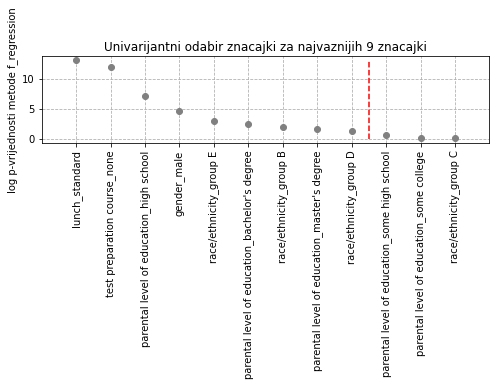

In [13]:
odaberi(feature_selection.f_regression,k_best,X_train_N, y_train_N,yname="f_regression")

### 2.Odabir encodinga za feature selection : Label


In [14]:
X_features_encoded = encode_data(df,enc_type="LABEL")
Y = df["AVERAGE"]

k_best = int(len(X_features_encoded.columns)*0.8) 

In [15]:
X_train_N, X_test_N, y_train_N, y_test_N = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    random_state=1
)

y_train_N=y_train_N.astype('int')

### Rezultat s metodom: f_regression

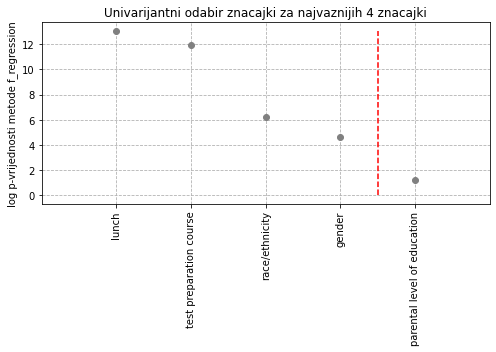

In [16]:
odaberi(feature_selection.f_regression,k_best,X_train_N, y_train_N,yname="f_regression")

Zaključak: 
Maknut ćemo značajku $\text{parental level of education}$, i vidjeti točnost modela bez nje.

# Modeli

Na raspolaganju imamo puno različitih algoritama strojnog učenja koje možemo primjeniti na ovaj problem. Ideja je da prvo krenemo od jednostavnijih, pa nadograđujemo prema onim kompleksnijim modelima. 
Za početak ćemo iskoristiti sljedeće algoritme:
        
        - Algoritmi regresije
        - Support vector machines (SVM)
        - Slučajne šume

## Priprema podataka

### Funkcije za ispis grešaka

In [17]:
def evaluateRegressor(true,predicted,message = "Test set evaluation:"):
    MSE = mean_squared_error(true,predicted,squared = True)
    MAE = mean_absolute_error(true,predicted)
    RMSE = mean_squared_error(true,predicted,squared = False)
    R_squared = r2_score(true,predicted)
    print(message)
    print("MSE:", MSE)
    print("MAE:", MAE)
    print("RMSE:", RMSE)
    print(f"R-squared: {R_squared} , from <0,1> ")
    return [MSE,MAE,RMSE,R_squared]

### Train Test Split
Pošto nemamo unaprijed zadane trening i test podatke, uobičajeno je podijeliti cijelu našu bazu u dio za trening i dio za test. Najčešće se koristi sklearn funkcija train_test_split koja prima postotak podataka koji želimo da bude testni. U našem slučaju stavit ćemo 20% (800 trening, 200 test podataka).

    X_features_encoded:    dataset kodiran pomoću odabranog encodinga
    X_features_encoded_FS: isti dataset bez stupca kojeg smo maknuli feature selectionom
    Y:                     skup oznaka (numerički)
    Y_class:               skup oznaka (kategorički, ocjene od 1 do 5) 
    

In [18]:
#KOJI CEMO ENCODING KORISTITI
encoding= "LABEL"

feature_selection_column="lunch"

numeric_cols=["math score","reading score","writing score","AVERAGE"]

In [19]:
Y = df["AVERAGE"]
Y_class= pd.cut(Y,
       5, labels=[1,2,3,4,5])

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(numeric_cols,axis = 'columns'), 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    #random_state=1
)
#y_train_N=y_train_N.astype('int')

X_train = encode_data(X_train,removeY=False,enc_type=encoding)
X_test = encode_data(X_test,removeY=False,enc_type=encoding)

X_train_FS = X_train.drop([feature_selection_column],axis = 'columns')
X_test_FS = X_test.drop([feature_selection_column],axis = 'columns')


In [20]:
df_temp = df.copy()
df_temp['Total score'] = ((df['math score']+df['writing score']+df['reading score'])/3).round(2)
df_temp=df_temp.drop(["AVERAGE"],axis = 'columns')

In [21]:
df2 = one_hot_encoding(df_temp)
train, test = train_test_split(df2, test_size=0.2)
features = train.loc[:, 'gender' : 'test preparation course']
targets = train.loc[:, 'math score' : 'Total score']

Ako ce nam trebat skalirani podaci ,tu su

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Evaluacije spremamo u tablicu

In [23]:
data=[]
data=pd.DataFrame(data, columns=["MSE", "MAE","RMSE", "R^2"])
data.index.astype(str, copy = False)

data

,MSE,MAE,RMSE,R^2


## Modeli linearne regresije

Osnovni algoritam regresije (a i cijele teorije strojnog učenja) je linearna regresija. Osim nje, postoje i neke modifikacije. Svaka ima svoje prednosti i mane, zbog kojih se sve koriste u određenim situacijama. Mi ćemo iskoristiti Lasso i Ridge, te usporediti rezultate svih.

### Linearna Regresija

In [24]:
model = Pipeline([ ('linear', LinearRegression()) ])
model = model.fit(features, targets)

regr_pred = model.predict(test.loc[:, 'gender' : 'test preparation course'])
print(regr_pred)

correct_scores = test.loc[:, 'math score' : 'Total score']
explained_variance = explained_variance_score(correct_scores, regr_pred)
R2 = r2_score(correct_scores, regr_pred)
MSE = mean_squared_error(correct_scores, regr_pred)

print('Objasnjena varijanca = '+'{0:.2f}'.format(explained_variance)+'\nR2 = '+'{0:.2f}'.format(R2)+'\nMSE = '+'{0:.2f}'.format(MSE))

[[61.64200503 68.7480273  66.56251426 65.65044788]
 [82.59816686 75.51273077 75.12202625 77.74389929]
 [71.50159064 79.5587337  80.85477738 77.30509887]
 [65.48929141 72.93861084 71.9685826  70.13195454]
 [65.7945974  66.60826262 65.31665568 65.90615349]
 [63.30484405 63.29246069 59.61052706 62.06890114]
 [68.11065596 63.32744867 60.87215892 64.10371048]
 [65.21896483 60.94911565 56.91085929 61.02624877]
 [76.5749874  73.74325627 73.46776426 74.59504848]
 [61.11519037 68.96912706 66.39502401 65.49292132]
 [72.83525836 68.32598728 66.81016129 69.32375183]
 [70.81792693 68.38437712 67.13478711 68.77912608]
 [64.00596278 74.07977798 74.73421331 70.93963663]
 [62.49937579 58.50217481 54.61902481 58.54002912]
 [59.45982561 70.19994269 71.3450985  67.00210192]
 [72.93608726 82.26953448 85.35173931 80.18635487]
 [67.45874033 76.75199584 78.80989768 74.34007469]
 [68.11065596 63.32744867 60.87215892 64.10371048]
 [59.28571113 57.99806553 54.0019496  57.09473866]
 [70.8065276  68.26204682 66.72

In [25]:
LinearReg = LinearRegression(normalize = True)
LinearReg = LinearReg.fit(X_train,y_train)

LinearReg_FS = LinearRegression(normalize = True)
LinearReg_FS = LinearReg_FS.fit(X_train_FS,y_train)

predicted_y_test = LinearReg.predict(X_test)
predicted_y_test_FS=LinearReg_FS.predict(X_test_FS)

In [26]:
data.loc['linearna'] = evaluateRegressor(y_test, predicted_y_test)
data.loc['linearna_fs'] = evaluateRegressor(y_test, predicted_y_test_FS)

data

Test set evaluation:
MSE: 148.63318478045952
MAE: 9.72445914880865
RMSE: 12.191521019973656
R-squared: 0.23410002675434627 , from <0,1> 
Test set evaluation:
MSE: 174.23887147996814
MAE: 10.517873694754599
RMSE: 13.19995725295988
R-squared: 0.10215509946871004 , from <0,1> 


,MSE,MAE,RMSE,R^2
linearna,148.633185,9.724459,12.191521,0.234100
linearna_fs,174.238871,10.517874,13.199957,0.102155


### MultitaskLasso Regresija (3 izlaza)

In [27]:
X_lasso =df.drop(["math score","reading score","writing score","AVERAGE"],axis = 'columns') 
Y_3_lasso =df[["math score","reading score","writing score"]]

X_lasso = encode_data(X_lasso,enc_type="LABEL",removeY=False)

In [28]:
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(
    X_lasso, 
    Y_3_lasso, 
    test_size=0.2, 
    shuffle = True, 
    #random_state=1
)

In [29]:
# import linear model library
from sklearn import linear_model
  
# create MultiTaskLasso model
MTL = linear_model.MultiTaskLasso(alpha = 0.5)

# fit the model to a data
#MTL.fit([[1, 0], [1, 3], [2, 2]], [[0, 2], [1, 4], [2, 4]])
MTL.fit(X_train_lasso,y_train_lasso)

pred=MTL.predict(X_test_lasso)
# perform prediction and print the result
#print("Prediciton result: \n", MTL.predict(X_test_lasso), "\n")
  
# print the coefficients
#print("Coefficients: \n", MTL.coef_, "\n")
  
# print the intercepts
#print("Intercepts: \n", MTL.intercept_, "\n")
  
# print the number of iterations performed
#print("Number of Iterations: ", MTL.n_iter_, "\n")

In [30]:
#residual(y_test_lasso, pred)

print("\nScores:")

data.loc['Multi-Lasso'] = evaluateRegressor(y_test_lasso, pred)


Scores:
Test set evaluation:
MSE: 166.9230622085013
MAE: 10.490069141450947
RMSE: 12.91643784344213
R-squared: 0.2464351768970936 , from <0,1> 


## Ridge regresija

Objasnjena varijanca = 0.27
R2 = 0.27
MSE = 163.91


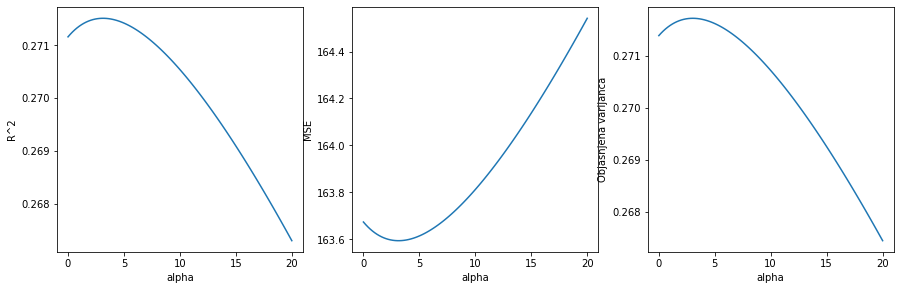

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))
alpha_array = np.linspace(0.01, 20.0, 100)
R2 = []
MSE = []
explained_variance = []

for alpha in alpha_array:
    model_ridge = Pipeline( [ ('ridge', Ridge(alpha=alpha)) ] )
    model_ridge = model_ridge.fit(features, targets)
    #R2_ridge = model_ridge.score(test.loc[:, 'gender' : 'test preparation course'], correct_scores)
    regr_pred = model_ridge.predict(test.loc[:, 'gender' : 'test preparation course'])
    
    
    explained_variance.append(explained_variance_score(correct_scores, regr_pred))
    R2.append(r2_score(correct_scores, regr_pred))
    MSE.append(mean_squared_error(correct_scores, regr_pred))

def avg(arr):
    return sum(arr) / len(arr)

print('Objasnjena varijanca = '+'{0:.2f}'.format(avg(explained_variance))+'\nR2 = '+'{0:.2f}'.format(avg(R2))+'\nMSE = '+'{0:.2f}'.format(avg(MSE)))


ax[0].plot(alpha_array, R2)
ax[0].set(xlabel='alpha', ylabel='R^2')
ax[1].plot(alpha_array, MSE)
ax[1].set(xlabel='alpha', ylabel='MSE')
ax[2].plot(alpha_array, explained_variance)
ax[2].set(xlabel='alpha', ylabel='Objasnjena varijanca')

plt.show()

## LightGBM

In [32]:
LGBMReg = lgb.LGBMRegressor(random_state=0).fit(X_train,y_train)
LGBMReg_FS = lgb.LGBMRegressor(random_state=0).fit(X_train_FS,y_train)

#predicted_y_train = LGBMReg.predict(X_train)
#evaluateRegressor(y_train,predicted_y_train,"    Training Set")

predicted_y_test = LGBMReg.predict(X_test)
data.loc['LightGBM'] = evaluateRegressor(y_test,predicted_y_test)

predicted_y_test_FS = LGBMReg_FS.predict(X_test_FS)
data.loc['LightGBM_FS'] = evaluateRegressor(y_test,predicted_y_test_FS)


Test set evaluation:
MSE: 187.41623880493253
MAE: 11.047363724589747
RMSE: 13.69000506957293
R-squared: 0.03425273098655912 , from <0,1> 
Test set evaluation:
MSE: 198.849402480001
MAE: 11.537236365623198
RMSE: 14.101397181839856
R-squared: -0.024661836213102584 , from <0,1> 


### Koji atributi najviše pridonose modelu LightGBM

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

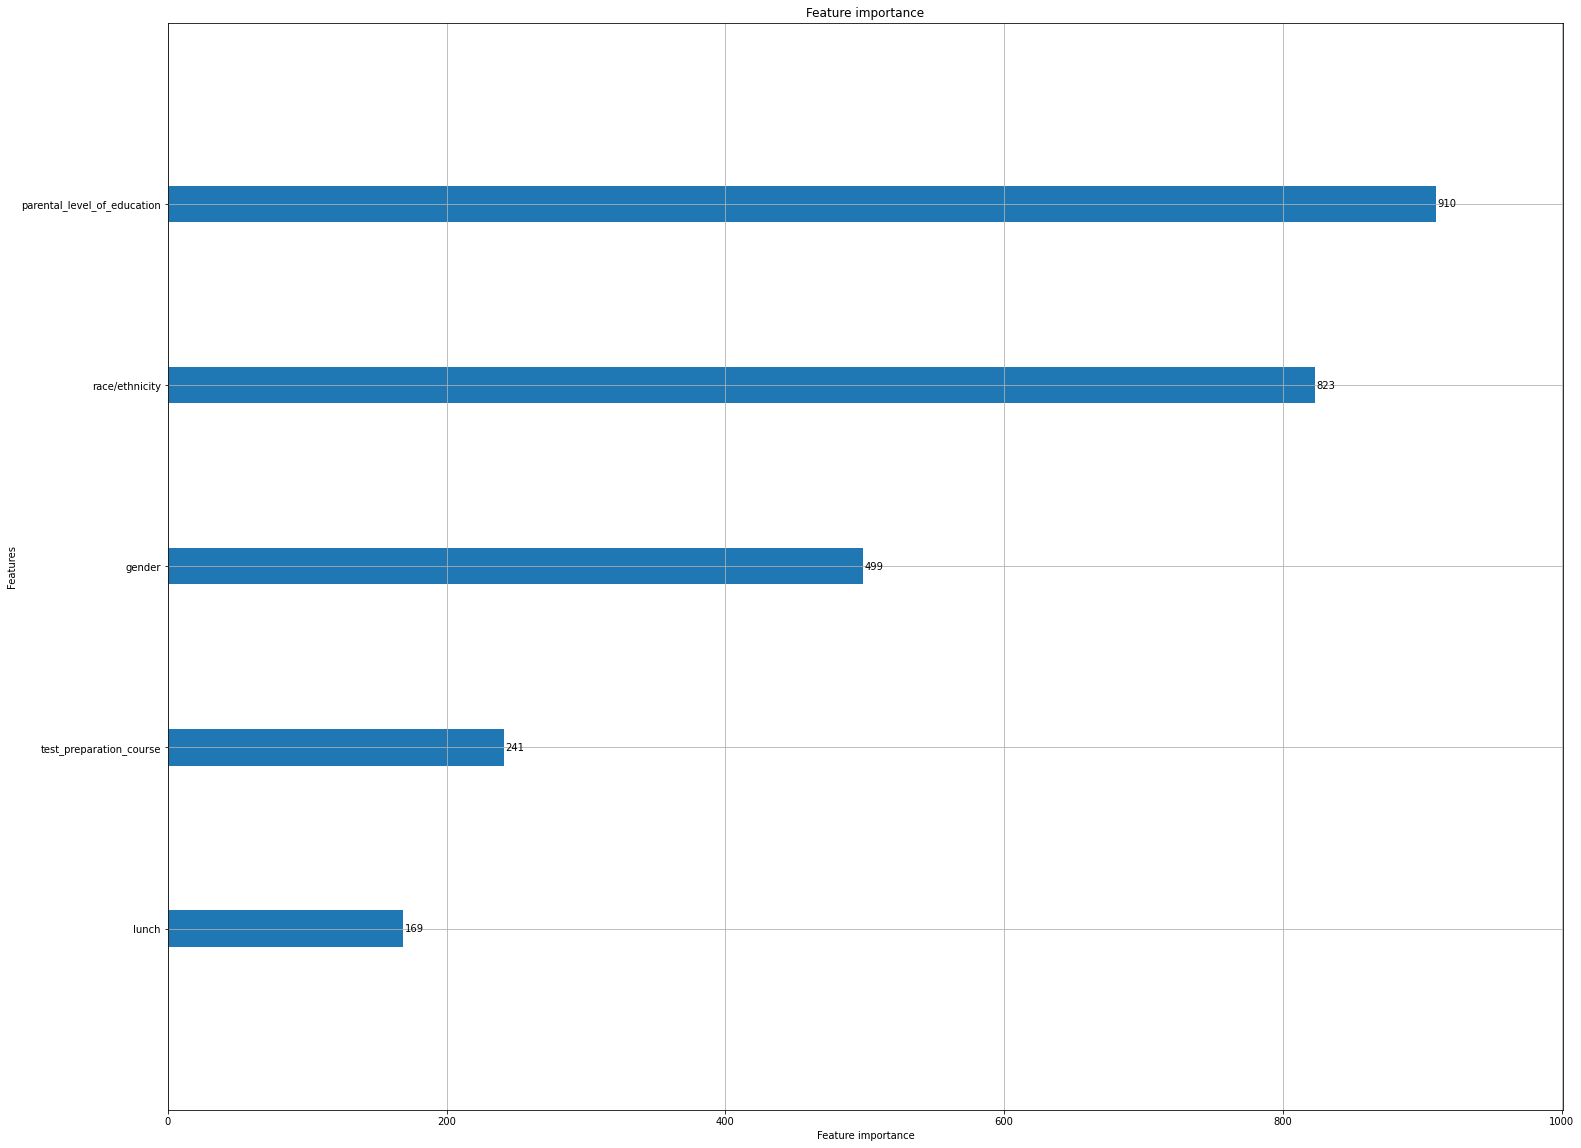

In [33]:
lgb.plot_importance(LGBMReg,figsize=(25,20))

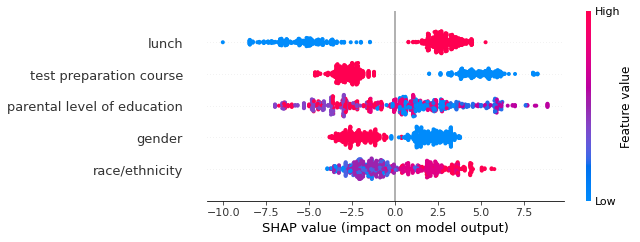

In [34]:
#LGBMReg.params['objective'] = 'regression'
shap_values = shap.TreeExplainer(LGBMReg).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

## k Najbližih susjeda (kNN)

In [35]:
from sklearn import neighbors

mse = []
mse_train=[]
maxx=[]
maxx_train=[]
r2=[]
r2_train=[]

for i in range(150):
    i = i+1
    model = neighbors.KNeighborsRegressor(n_neighbors = i)
    model.fit(X_train, y_train) 
    pred=model.predict(X_test) 
    pred_train=model.predict(X_train) 
    
    mse.append(mean_squared_error(y_test,pred)) 
    mse_train.append(mean_squared_error(y_train,pred_train)) 
    
    maxx.append(max_error(y_test,pred)) 
    maxx_train.append(max_error(y_train,pred_train)) 
    
    r2.append(r2_score(y_test,pred)) 
    r2_train.append(r2_score(y_train,pred_train)) 
    
    


In [36]:
mse2=pd.DataFrame({"k": range(1,151),"MSE": mse})
min_index_mse = mse2.iloc[:,1].idxmin()

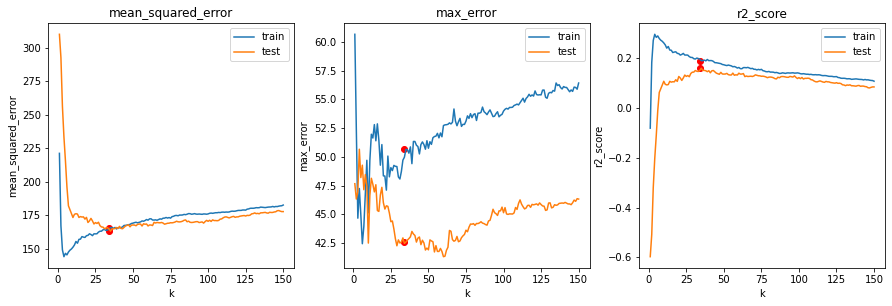

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))

train=[mse_train,maxx_train,r2_train]
test=[mse,maxx,r2]
labels=["mean_squared_error","max_error","r2_score"]
titles=["mean_squared_error","max_error","r2_score"]


for i in range(3):
    tr= train[i]
    ts= test[i]
    ylab=labels[i]
    title=titles[i]
    
    ax[i].plot(min_index_mse,tr[min_index_mse],'ro')
    ax[i].plot(min_index_mse,ts[min_index_mse],'ro')
    
    ax[i].plot(np.arange(1,150+1),tr,label='train')
    ax[i].plot(np.arange(1,150+1),ts,label='test')
    
    ax[i].set(xlabel='k')
    ax[i].set(ylabel=ylab)
    ax[i].title.set_text(title)
    ax[i].legend()




plt.show()

### Uzimamo onaj model s najmanjim MSE

In [38]:
model = neighbors.KNeighborsRegressor(n_neighbors =min_index_mse)
model.fit(X_train, y_train) 

model_FS = neighbors.KNeighborsRegressor(n_neighbors = min_index_mse)
model_FS.fit(X_train_FS, y_train) 

pred=model.predict(X_test)
pred_FS=model_FS.predict(X_test_FS)

In [39]:
data.loc['kNN'] = evaluateRegressor(y_test, pred)
data.loc['kNN_FS'] = evaluateRegressor(y_test, pred_FS)

Test set evaluation:
MSE: 164.64885909265666
MAE: 10.426470588235293
RMSE: 12.831557157752004
R-squared: 0.15157199275345234 , from <0,1> 
Test set evaluation:
MSE: 179.5324312764321
MAE: 10.99122549019608
RMSE: 13.39897127679704
R-squared: 0.07487762901367989 , from <0,1> 


## CATBoost

### Pretraživanje hiperparametra: $iterations$

In [40]:
from catboost import CatBoostRegressor

train_data = X_train
eval_data = X_test
train_labels = y_train


k=50

treeScoresTest1=np.zeros(k)
treeScoresTrain1=np.zeros(k)
treeScoresTest2=np.zeros(k)
treeScoresTrain2=np.zeros(k)
treeScoresTest3=np.zeros(k)
treeScoresTrain3=np.zeros(k)

for i in np.arange(1,k+1):
        # Initialize CatBoostRegressor
    model = CatBoostRegressor(iterations=i,
                              learning_rate=1,
                              depth=2)
    # Fit model
    model.fit(train_data, train_labels)
    
    
    treeScoresTrain1[i-1]=r2_score(y_train, model.predict(X_train))
    treeScoresTest1[i-1] =r2_score(y_test, model.predict(X_test))
    treeScoresTrain2[i-1]= max_error(y_train, model.predict(X_train))
    treeScoresTest2[i-1] = max_error(y_test, model.predict(X_test))
    treeScoresTrain3[i-1]= mean_squared_error (y_train, model.predict(X_train))
    treeScoresTest3[i-1] = mean_squared_error (y_test, model.predict(X_test))


0:	learn: 13.2181035	total: 156ms	remaining: 0us
0:	learn: 13.2181035	total: 578us	remaining: 578us
1:	learn: 13.0512733	total: 1.25ms	remaining: 0us
0:	learn: 13.2181035	total: 637us	remaining: 1.27ms
1:	learn: 13.0512733	total: 1.22ms	remaining: 609us
2:	learn: 12.7289584	total: 1.87ms	remaining: 0us
0:	learn: 13.2181035	total: 615us	remaining: 1.85ms
1:	learn: 13.0512733	total: 1.26ms	remaining: 1.26ms
2:	learn: 12.7289584	total: 1.77ms	remaining: 591us
3:	learn: 12.6560543	total: 2.44ms	remaining: 0us
0:	learn: 13.2181035	total: 561us	remaining: 2.25ms
1:	learn: 13.0512733	total: 1.45ms	remaining: 2.18ms
2:	learn: 12.7289584	total: 2.05ms	remaining: 1.37ms
3:	learn: 12.6560543	total: 2.7ms	remaining: 674us
4:	learn: 12.5935775	total: 3.25ms	remaining: 0us
0:	learn: 13.2181035	total: 559us	remaining: 2.8ms
1:	learn: 13.0512733	total: 1.3ms	remaining: 2.61ms
2:	learn: 12.7289584	total: 1.9ms	remaining: 1.9ms
3:	learn: 12.6560543	total: 2.49ms	remaining: 1.25ms
4:	learn: 12.5935775	to

0:	learn: 13.2181035	total: 569us	remaining: 10.3ms
1:	learn: 13.0512733	total: 1.27ms	remaining: 10.8ms
2:	learn: 12.7289584	total: 1.76ms	remaining: 9.37ms
3:	learn: 12.6560543	total: 2.32ms	remaining: 8.69ms
4:	learn: 12.5935775	total: 2.83ms	remaining: 7.93ms
5:	learn: 12.5485484	total: 3.39ms	remaining: 7.35ms
6:	learn: 12.4595117	total: 3.92ms	remaining: 6.71ms
7:	learn: 12.4549330	total: 4.4ms	remaining: 6.05ms
8:	learn: 12.4076377	total: 5.03ms	remaining: 5.59ms
9:	learn: 12.3961922	total: 5.6ms	remaining: 5.04ms
10:	learn: 12.3867895	total: 6.23ms	remaining: 4.53ms
11:	learn: 12.3619031	total: 7.08ms	remaining: 4.13ms
12:	learn: 12.3573525	total: 7.61ms	remaining: 3.51ms
13:	learn: 12.3495829	total: 8.29ms	remaining: 2.96ms
14:	learn: 12.3447129	total: 9.19ms	remaining: 2.45ms
15:	learn: 12.3428403	total: 9.73ms	remaining: 1.82ms
16:	learn: 12.3347758	total: 10.4ms	remaining: 1.22ms
17:	learn: 12.3333938	total: 10.9ms	remaining: 605us
18:	learn: 12.3284894	total: 11.8ms	remain

1:	learn: 13.0512733	total: 1.74ms	remaining: 20.9ms
2:	learn: 12.7289584	total: 2.27ms	remaining: 17.4ms
3:	learn: 12.6560543	total: 2.8ms	remaining: 15.4ms
4:	learn: 12.5935775	total: 3.35ms	remaining: 14.1ms
5:	learn: 12.5485484	total: 3.92ms	remaining: 13.1ms
6:	learn: 12.4595117	total: 4.41ms	remaining: 12ms
7:	learn: 12.4549330	total: 4.88ms	remaining: 11ms
8:	learn: 12.4076377	total: 5.35ms	remaining: 10.1ms
9:	learn: 12.3961922	total: 5.81ms	remaining: 9.3ms
10:	learn: 12.3867895	total: 6.28ms	remaining: 8.56ms
11:	learn: 12.3619031	total: 6.75ms	remaining: 7.87ms
12:	learn: 12.3573525	total: 7.19ms	remaining: 7.19ms
13:	learn: 12.3495829	total: 7.66ms	remaining: 6.57ms
14:	learn: 12.3447129	total: 8.14ms	remaining: 5.97ms
15:	learn: 12.3428403	total: 8.63ms	remaining: 5.4ms
16:	learn: 12.3347758	total: 9.17ms	remaining: 4.86ms
17:	learn: 12.3333938	total: 9.66ms	remaining: 4.29ms
18:	learn: 12.3284894	total: 10.1ms	remaining: 3.73ms
19:	learn: 12.3102530	total: 10.6ms	remainin

20:	learn: 12.3081018	total: 11.3ms	remaining: 5.37ms
21:	learn: 12.3067132	total: 11.9ms	remaining: 4.85ms
22:	learn: 12.3006476	total: 12.4ms	remaining: 4.32ms
23:	learn: 12.2974096	total: 12.9ms	remaining: 3.77ms
24:	learn: 12.2891953	total: 13.4ms	remaining: 3.22ms
25:	learn: 12.2857764	total: 14.1ms	remaining: 2.71ms
26:	learn: 12.2856896	total: 15.6ms	remaining: 2.31ms
27:	learn: 12.2801336	total: 16.1ms	remaining: 1.72ms
28:	learn: 12.2779557	total: 16.6ms	remaining: 1.15ms
29:	learn: 12.2715856	total: 17.1ms	remaining: 569us
30:	learn: 12.2699079	total: 17.5ms	remaining: 0us
0:	learn: 13.2181035	total: 555us	remaining: 17.2ms
1:	learn: 13.0512733	total: 1.05ms	remaining: 15.7ms
2:	learn: 12.7289584	total: 1.46ms	remaining: 14.1ms
3:	learn: 12.6560543	total: 1.9ms	remaining: 13.3ms
4:	learn: 12.5935775	total: 2.68ms	remaining: 14.5ms
5:	learn: 12.5485484	total: 3.12ms	remaining: 13.5ms
6:	learn: 12.4595117	total: 3.58ms	remaining: 12.8ms
7:	learn: 12.4549330	total: 4.01ms	remain

32:	learn: 12.2642601	total: 21.5ms	remaining: 1.96ms
33:	learn: 12.2624777	total: 22ms	remaining: 1.3ms
34:	learn: 12.2587369	total: 22.6ms	remaining: 644us
35:	learn: 12.2584900	total: 23.1ms	remaining: 0us
0:	learn: 13.2181035	total: 725us	remaining: 26.1ms
1:	learn: 13.0512733	total: 1.32ms	remaining: 23.2ms
2:	learn: 12.7289584	total: 1.83ms	remaining: 20.8ms
3:	learn: 12.6560543	total: 2.33ms	remaining: 19.2ms
4:	learn: 12.5935775	total: 2.94ms	remaining: 18.8ms
5:	learn: 12.5485484	total: 3.49ms	remaining: 18ms
6:	learn: 12.4595117	total: 4.03ms	remaining: 17.3ms
7:	learn: 12.4549330	total: 5.74ms	remaining: 20.8ms
8:	learn: 12.4076377	total: 6.64ms	remaining: 20.7ms
9:	learn: 12.3961922	total: 7.13ms	remaining: 19.3ms
10:	learn: 12.3867895	total: 7.55ms	remaining: 17.9ms
11:	learn: 12.3619031	total: 8.01ms	remaining: 16.7ms
12:	learn: 12.3573525	total: 8.42ms	remaining: 15.5ms
13:	learn: 12.3495829	total: 8.82ms	remaining: 14.5ms
14:	learn: 12.3447129	total: 9.26ms	remaining: 1

0:	learn: 13.2181035	total: 624us	remaining: 25.6ms
1:	learn: 13.0512733	total: 1.31ms	remaining: 26.2ms
2:	learn: 12.7289584	total: 1.85ms	remaining: 24ms
3:	learn: 12.6560543	total: 2.35ms	remaining: 22.4ms
4:	learn: 12.5935775	total: 2.84ms	remaining: 21ms
5:	learn: 12.5485484	total: 3.32ms	remaining: 19.9ms
6:	learn: 12.4595117	total: 3.79ms	remaining: 19ms
7:	learn: 12.4549330	total: 4.36ms	remaining: 18.5ms
8:	learn: 12.4076377	total: 4.96ms	remaining: 18.2ms
9:	learn: 12.3961922	total: 5.58ms	remaining: 17.9ms
10:	learn: 12.3867895	total: 6.05ms	remaining: 17ms
11:	learn: 12.3619031	total: 6.53ms	remaining: 16.3ms
12:	learn: 12.3573525	total: 7.01ms	remaining: 15.6ms
13:	learn: 12.3495829	total: 7.62ms	remaining: 15.2ms
14:	learn: 12.3447129	total: 8.12ms	remaining: 14.6ms
15:	learn: 12.3428403	total: 8.62ms	remaining: 14ms
16:	learn: 12.3347758	total: 9.23ms	remaining: 13.6ms
17:	learn: 12.3333938	total: 9.9ms	remaining: 13.2ms
18:	learn: 12.3284894	total: 10.4ms	remaining: 12.

38:	learn: 12.2463404	total: 17.8ms	remaining: 3.64ms
39:	learn: 12.2443459	total: 18.3ms	remaining: 3.2ms
40:	learn: 12.2410605	total: 18.9ms	remaining: 2.76ms
41:	learn: 12.2398405	total: 19.4ms	remaining: 2.31ms
42:	learn: 12.2382401	total: 19.9ms	remaining: 1.85ms
43:	learn: 12.2346043	total: 20.4ms	remaining: 1.39ms
44:	learn: 12.2333296	total: 20.9ms	remaining: 927us
45:	learn: 12.2310187	total: 21.3ms	remaining: 463us
46:	learn: 12.2304255	total: 21.8ms	remaining: 0us
0:	learn: 13.2181035	total: 828us	remaining: 38.9ms
1:	learn: 13.0512733	total: 1.4ms	remaining: 32.1ms
2:	learn: 12.7289584	total: 1.83ms	remaining: 27.5ms
3:	learn: 12.6560543	total: 2.25ms	remaining: 24.7ms
4:	learn: 12.5935775	total: 2.72ms	remaining: 23.4ms
5:	learn: 12.5485484	total: 3.19ms	remaining: 22.4ms
6:	learn: 12.4595117	total: 3.62ms	remaining: 21.2ms
7:	learn: 12.4549330	total: 4.02ms	remaining: 20.1ms
8:	learn: 12.4076377	total: 4.45ms	remaining: 19.3ms
9:	learn: 12.3961922	total: 4.89ms	remaining:

Max test: 0.219
Max train:0.269
Max test index:2


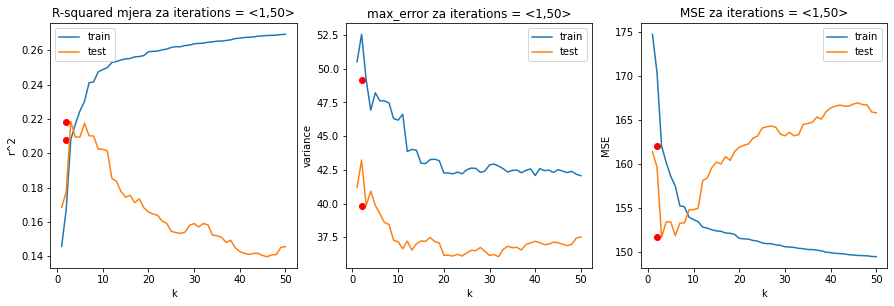

In [41]:
maximumTE = np.max(treeScoresTest1)
minimumTR = np.max(treeScoresTrain1)

print("Max test: " + str(round(maximumTE,3)) )
print("Max train:" + str(round(minimumTR,3)) )

index_of_maximum = np.where(treeScoresTest1 == maximumTE)[0][0]
print("Max test index:" + str(index_of_maximum) )


fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))

train=[treeScoresTrain1,treeScoresTrain2,treeScoresTrain3]
test=[treeScoresTest1,treeScoresTest2,treeScoresTest3]
labels=["r^2","variance","MSE"]
titles=[f"R-squared mjera za iterations = <1,{k}>",f"max_error za iterations = <1,{k}>",f"MSE za iterations = <1,{k}>"]

for i in range(3):
    tr= train[i]
    ts= test[i]
    ylab=labels[i]
    title=titles[i]
    
    ax[i].plot(index_of_maximum,tr[index_of_maximum],'ro')
    ax[i].plot(index_of_maximum,ts[index_of_maximum],'ro')
    
    ax[i].plot(np.arange(1,k+1),tr,label='train')
    ax[i].plot(np.arange(1,k+1),ts,label='test')
    
    ax[i].set(xlabel='k')
    ax[i].set(ylabel=ylab)
    ax[i].title.set_text(title)
    ax[i].legend()




plt.show()

### Najbolji hiperparametar $iterations$ nađen

In [42]:

model = CatBoostRegressor(iterations=index_of_maximum,
                          learning_rate=1,
                          depth=2)

model.fit(train_data, train_labels)

pred = model.predict(eval_data)

0:	learn: 13.2181035	total: 594us	remaining: 594us
1:	learn: 13.0512733	total: 1.33ms	remaining: 0us


In [43]:
print("\nScores:")
data.loc['CATBoost'] = evaluateRegressor(y_test, pred)


Scores:
Test set evaluation:
MSE: 159.63438942250875
MAE: 10.090748777419673
RMSE: 12.634650348249007
R-squared: 0.17741132460844966 , from <0,1> 


## ANN

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


model = Sequential()
model.add(Dense(100, input_dim=X_train.columns.value_counts().sum(), activation="softmax"))
model.add(Dense(100, activation="relu"))
model.add(Dense(1, kernel_initializer="normal"))
model.compile(loss="mean_squared_error", optimizer = "adam", metrics = ["mse"])

model.fit(X_train, y_train, epochs=10)

Epoch 1/10
25/25 [==============================] - 1s 2ms/step - loss: 4840.7119 - mse: 4840.7119
Epoch 2/10
25/25 [==============================] - 0s 2ms/step - loss: 4808.6846 - mse: 4808.6846
Epoch 3/10
25/25 [==============================] - 0s 2ms/step - loss: 4749.4746 - mse: 4749.4746
Epoch 4/10
25/25 [==============================] - 0s 2ms/step - loss: 4656.4033 - mse: 4656.4033
Epoch 5/10
25/25 [==============================] - 0s 2ms/step - loss: 4522.9995 - mse: 4522.9995
Epoch 6/10
25/25 [==============================] - 0s 2ms/step - loss: 4344.5049 - mse: 4344.5049
Epoch 7/10
25/25 [==============================] - 0s 2ms/step - loss: 4120.3110 - mse: 4120.3110
Epoch 8/10
25/25 [==============================] - 0s 2ms/step - loss: 3851.4910 - mse: 3851.4910
Epoch 9/10
25/25 [==============================] - 0s 2ms/step - loss: 3545.2520 - mse: 3545.2520
Epoch 10/10
25/25 [==============================] - 0s 2ms/step - loss: 3211.2546 - mse: 3211.2546


In [45]:
from tensorflow.keras.models import Model, load_model
#model.save('cnn_model.h5')
#model = load_model('cnn_model.h5')

predicted_y_test = model.predict(X_test)
predicted_y_test = pd.Series([i[0] for i in predicted_y_test])

In [46]:
data.loc['ANN'] = evaluateRegressor(y_test, predicted_y_test)

Test set evaluation:
MSE: 2818.133403913242
MAE: 51.23001924832661
RMSE: 53.08609426123984
R-squared: -13.521711970633872 , from <0,1> 


## Slučajne šume

### Pretraživanje hiperparametra: $n\_estimators$

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score,max_error

In [48]:
k=50

treeScoresTest1=np.zeros(k)
treeScoresTrain1=np.zeros(k)
treeScoresTest2=np.zeros(k)
treeScoresTrain2=np.zeros(k)
treeScoresTest3=np.zeros(k)
treeScoresTrain3=np.zeros(k)



#X_train, X_test, y_train, y_test 


for k in np.arange(1,k+1):
    rf = RandomForestRegressor(n_estimators=k)
    rf.fit(X_train,y_train)
    treeScoresTrain1[k-1]=r2_score(y_train, rf.predict(X_train))
    treeScoresTest1[k-1] =r2_score(y_test, rf.predict(X_test))
    treeScoresTrain2[k-1]= max_error(y_train, rf.predict(X_train))
    treeScoresTest2[k-1] = max_error(y_test, rf.predict(X_test))
    treeScoresTrain3[k-1]= mean_squared_error (y_train, rf.predict(X_train))
    treeScoresTest3[k-1] = mean_squared_error (y_test, rf.predict(X_test))

Max test: -0.071
Max train:0.409
Max test index:13


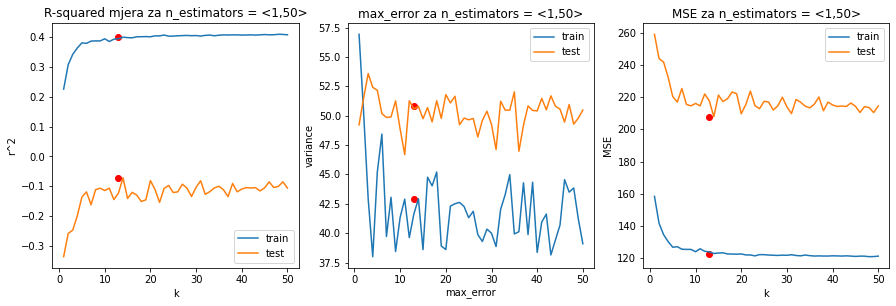

In [49]:

maximumTE = np.max(treeScoresTest1)
minimumTR = np.max(treeScoresTrain1)

print("Max test: " + str(round(maximumTE,3)) )
print("Max train:" + str(round(minimumTR,3)) )

index_of_maximum = np.where(treeScoresTest1 == maximumTE)[0][0]
print("Max test index:" + str(index_of_maximum) )


fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))


ax[0].plot(index_of_maximum,treeScoresTrain1[index_of_maximum],'ro')
ax[0].plot(index_of_maximum,treeScoresTest1[index_of_maximum],'ro')
ax[0].plot(np.arange(1,k+1),treeScoresTrain1,label='train')
ax[0].plot(np.arange(1,k+1),treeScoresTest1,label='test')
ax[0].set(xlabel='k', ylabel='r^2')
ax[0].title.set_text(f"R-squared mjera za n_estimators = <1,{k}>")
ax[0].legend()

ax[1].plot(index_of_maximum,treeScoresTrain2[index_of_maximum],'ro')
ax[1].plot(index_of_maximum,treeScoresTest2[index_of_maximum],'ro')

ax[1].plot(np.arange(1,k+1),treeScoresTrain2,label='train')
ax[1].plot(np.arange(1,k+1),treeScoresTest2,label='test')
ax[1].set(xlabel='max_error', ylabel='variance')
ax[1].title.set_text(f"max_error za n_estimators = <1,{k}>")
ax[1].legend()

ax[2].plot(index_of_maximum,treeScoresTrain3[index_of_maximum],'ro')
ax[2].plot(index_of_maximum,treeScoresTest3[index_of_maximum],'ro')

ax[2].plot(np.arange(1,k+1),treeScoresTrain3,label='train')
ax[2].plot(np.arange(1,k+1),treeScoresTest3,label='test')
ax[2].set(xlabel='k', ylabel='MSE')
ax[2].title.set_text(f"MSE za n_estimators = <1,{k}>")
ax[2].legend()


plt.show()



### Našli smo $\text{n_estimators}$ koji daje najmanju grešku nad $test$ skupom:

In [50]:
rf = RandomForestRegressor(n_estimators=index_of_maximum)
rf.fit(X_train,y_train)
# Predictions
predictions = rf.predict(X_test)

In [51]:

data.loc['Random forest'] =evaluateRegressor(y_test, predictions)

Test set evaluation:
MSE: 216.314979514894
MAE: 11.87564621393647
RMSE: 14.707650373696472
R-squared: -0.1146611523382528 , from <0,1> 


### Koji atributi doprinose najviše modelu slučajnih šuma

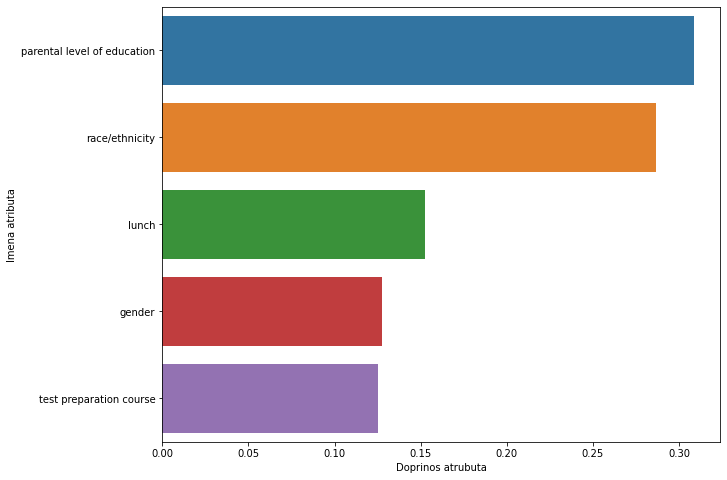

In [52]:
feature_importance = np.array(rf.feature_importances_)
feature_names = np.array(X_train.columns)
data2={'feature_names':feature_names,'feature_importance':feature_importance}
df_plt = pd.DataFrame(data2)
df_plt.sort_values(by=['feature_importance'], ascending=False,inplace=True)
plt.figure(figsize=(10,8))
sns.barplot(x=df_plt['feature_importance'], y=df_plt['feature_names'])
plt.xlabel('Doprinos atrubuta')
plt.ylabel('Imena atributa')
plt.show()

## SVM

In [53]:
from sklearn.svm import SVR
def SV_reg(kernel,X_train, y_train):
    model=SVR(kernel)
    model.fit(X_train, y_train)
    return model


SVM_model= SV_reg("linear",X_train, y_train)
pred_linear = SVM_model.predict(X_test)
linear_rmse = np.sqrt(mean_squared_error(y_test,pred_linear))

SVM_model= SV_reg("poly",X_train, y_train)
pred_poly = SVM_model.predict(X_test)
poly_rmse = np.sqrt(mean_squared_error(y_test,pred_poly))

SVM_model= SV_reg("sigmoid",X_train, y_train)
pred_sigmoid = SVM_model.predict(X_test)
sigmoid_rmse = np.sqrt(mean_squared_error(y_test,pred_sigmoid))

SVM_model= SV_reg("rbf",X_train, y_train)
pred_rbf = SVM_model.predict(X_test)
rbf_rmse = np.sqrt(mean_squared_error(y_test,pred_rbf))



data2 = {"kernel":pd.Series(["linear","polynomial","sigmoid","rbf"]),
            "Test RMSE":pd.Series([linear_rmse,poly_rmse,sigmoid_rmse,rbf_rmse])}
table_rmse=pd.DataFrame(data2)
table_rmse

,kernel,Test RMSE
0,linear,12.319460
1,polynomial,13.094923
2,sigmoid,23.739474
3,rbf,12.867293


### Umjesto ručnog pretraživanja hiperparametara $C$ i $\text{gamma}\ \gamma$ , koristimo funkciju $GridSearchCV$ za traženje hp. za 3 jezgrene fje. s najmanjom greškom

In [54]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

K = 15
#parameters = [{'kernel': ['linear','polynomial','rbf'], 'gamma': [2e-2, 2e-1, 1,  8],'C': [2e-3,2e-2, 2, 4]}]
#scorer = make_scorer(mean_squared_error, greater_is_better=False)
#svr_gs = GridSearchCV(SVR(epsilon = 0.01), parameters, cv = K, scoring=scorer)

#svr_gs.fit(X_train, y_train)
#print(svr_gs.best_params_)

 Naći čemo npr. {'C': 2, 'gamma': 0.002, 'kernel': 'linear'}

In [55]:
regressor = SVR(C=2,gamma=0.002,kernel='linear')
#regressor = SVR(**svr_gs.best_params_)
regressor.fit(X_train,y_train)
pred=regressor.predict(X_test)

In [56]:
data.loc['SVR_best'] = evaluateRegressor(y_test,pred)

Test set evaluation:
MSE: 151.0186038474562
MAE: 9.77971974788575
RMSE: 12.288962683947585
R-squared: 0.22180807188376317 , from <0,1> 


# DoWhy kauzalna analiza

## Priprema podataka

In [57]:
data_X_labeled= encode_data(df,enc_type="LABEL")
data_y_labeled= pd.cut(Y,
       5, labels=[1,2,3,4,5])

spojeno = pd.concat([data_X_labeled, data_y_labeled], axis=1)

In [58]:
spojeno.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'AVERAGE'],
      dtype='object')

## Analiza

In [59]:
import dowhy
from dowhy import CausalModel

In [60]:
model=CausalModel(
        data = spojeno,
        treatment='lunch',
        outcome='AVERAGE',
        common_causes=['gender','test preparation course', 'parental level of education','race/ethnicity']
        )

In [61]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(AVERAGE|gender,race/ethnicity,parental level of education
d[lunch]                                                                      

                          
,test preparation course))
                          
Estimand assumption 1, Unconfoundedness: If U→{lunch} and U→AVERAGE then P(AVERAGE|lunch,gender,race/ethnicity,parental level of education,test preparation course,U) = P(AVERAGE|lunch,gender,race/ethnicity,parental level of education,test preparation course)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [62]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance=True)
print(estimate)
print("Causal Estimate is " + str(estimate.value))
data_1 = spojeno[spojeno["lunch"]==1]
data_0 = spojeno[spojeno["race/ethnicity"]==0]
print("ATE", np.mean(data_1["AVERAGE"].cat.codes)- np.mean(data_0["AVERAGE"].cat.codes))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(AVERAGE|gender,race/ethnicity,parental level of education
d[lunch]                                                                      

                          
,test preparation course))
                          
Estimand assumption 1, Unconfoundedness: If U→{lunch} and U→AVERAGE then P(AVERAGE|lunch,gender,race/ethnicity,parental level of education,test preparation course,U) = P(AVERAGE|lunch,gender,race/ethnicity,parental level of education,test preparation course)

## Realized estimand
b: AVERAGE~lunch+gender+race/ethnicity+parental level of education+test preparation course
Target units: ate

## Estimate
Mean value: 0.48169465924595434
p-value: [5.06520702e-22]

Causal Estimate is 0.48169465924595434
ATE 0.4540545248671717


refute steps

    The refute steps tests the strength and validity of the causal effect found by the estimate step. There are a variety of different refutation methods, eg. Subset Validation (using only a subset of the data to estimate the causal effect) or Placebo Treatment (turning the treatment into a placebo and seeing its effect on the outcome (the placebo treatment refutation expects the causal effect to go down)) In this case, we’ll be adding an irrelevant common cause to test the strength of the causal relationship between the treatment and outcome. This is useful because it changes the causal model but not the relationship between y_factual and treatment.

In [63]:
refute_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute_results)

Refute: Add a Random Common Cause
Estimated effect:0.48169465924595434
New effect:0.4793824566590308



Adding a random common cause didn’t have much of an effect on the causal effect (as expected) and so we can be more assured of the strength of the causal relationship.

# Rezultati & zaključak

Usporedimo rezultate koje smo dobili:

In [64]:
data

,MSE,MAE,RMSE,R^2
linearna,148.633185,9.724459,12.191521,0.234100
linearna_fs,174.238871,10.517874,13.199957,0.102155
Multi-Lasso,166.923062,10.490069,12.916438,0.246435
LightGBM,187.416239,11.047364,13.690005,0.034253
LightGBM_FS,198.849402,11.537236,14.101397,-0.024662
kNN,164.648859,10.426471,12.831557,0.151572
kNN_FS,179.532431,10.991225,13.398971,0.074878
CATBoost,159.634389,10.090749,12.634650,0.177411
ANN,2818.133404,51.230019,53.086094,-13.521712
Random forest,216.314980,11.875646,14.707650,-0.114661


    U svim modelima predviđeni rezultati imaju dosta veliku grešku. To je možda zato što je skup malen te su atributi kategoričke varijable, te zato što dane varijable jednostavno nemaju nikakvu uzročno posljedičnu vezu oznakama ,tj. rezultatima ispita. Možda bi nam više pomogle varijable koje se odnose više na samog učenika, koliko je sati učio tjedno ili koliko je redovan na nastavi itd.